### `Step 1: Choose the dataset and convert images into grayscale.`

In [15]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.callbacks import EarlyStopping

In [16]:
data_dir = "flowers"

In [17]:
classes = os.listdir(data_dir)
print(classes)

['daisy']


In [18]:
X_gray = []
Y_color = []
labels = []

for label, class_name in enumerate(classes):
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)

            img = cv2.imread(img_path)


            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                img = cv2.resize(img, (200, 200))
                
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

                X_gray.append(gray)
                Y_color.append(img)
                labels.append(label)

In [19]:
X_gray = np.array(X_gray, dtype=np.float32).reshape(-1, 200, 200, 1) / 255.0
Y_color = np.array(Y_color, dtype=np.float32) / 255.0
labels = np.array(labels)

In [20]:
X_train, X_temp, Y_train, Y_temp = train_test_split(X_gray, Y_color, test_size=0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

In [21]:
print(f"#Training set: {len(X_train)}")
print(f"#Validation set: {len(X_val)}")
print(f"#Test set: {len(X_test)}")

#Training set: 534
#Validation set: 115
#Test set: 115


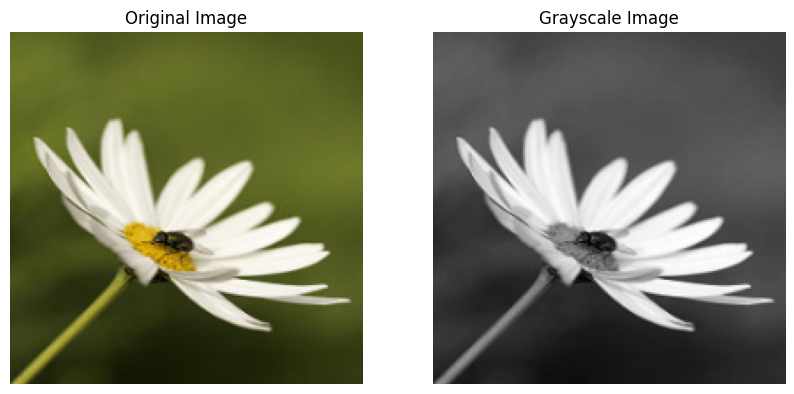

In [22]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(Y_train[0])  
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Grayscale Image")
plt.imshow(X_train[0].squeeze(), cmap="gray")  
plt.axis("off")

plt.show()

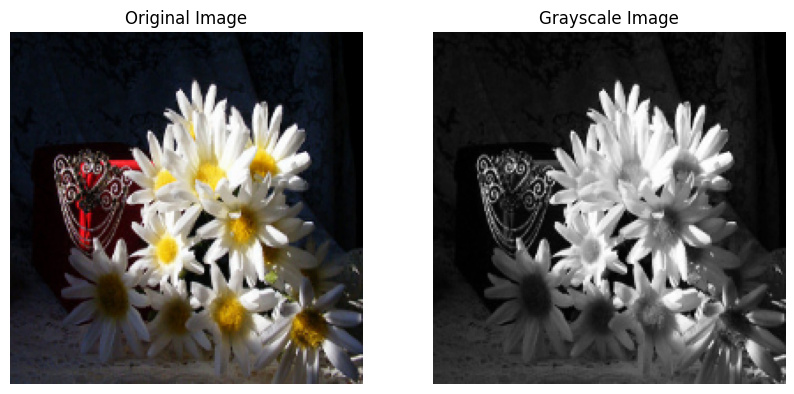

In [23]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(Y_train[1])  
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Grayscale Image")
plt.imshow(X_train[1].squeeze(), cmap="gray")  
plt.axis("off")

plt.show()

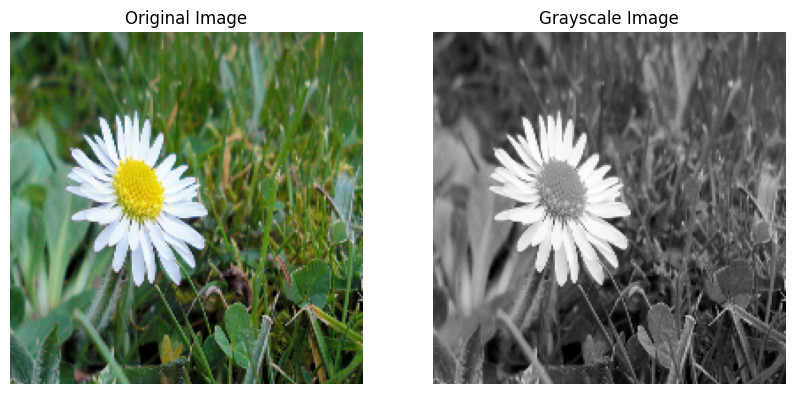

In [24]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(Y_train[10])  
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Grayscale Image")
plt.imshow(X_train[10].squeeze(), cmap="gray")  
plt.axis("off")

plt.show()

### `Step 2: Model, ready architecture trained from scratch.`

In [25]:
input_shape = (200, 200, 1)

# ENCODER
def build_encoder(input_layer):
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    return x

# DECODER
def build_decoder(encoded_layer):
    x = Conv2DTranspose(256, (3, 3), activation='relu', padding='same')(encoded_layer)
    x = UpSampling2D((2, 2))(x)
    x = Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    output_layer = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    return output_layer

In [26]:
input_layer = Input(shape=input_shape)
encoded = build_encoder(input_layer)
decoded = build_decoder(encoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 200, 200, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 200, 200, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 100, 100, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 100, 100, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 50, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 50, 50, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 25, 25, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 25, 25, 256)    │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 50, 50, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 50, 50, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_4 (UpSampling2D)  │ (None, 100, 100, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 100, 100, 64)   │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_5 (UpSampling2D)  │ (None, 200, 200, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 200, 200, 3)    │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,330,307 (5.07 MB)

 Trainable params: 1,330,307 (5.07 MB)

 Non-trainable params: 0 (0.00 B)

### `Step 3: Training the model.`

In [27]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience=5, restore_best_weights=True)

In [28]:
batch_size = 32
epochs = 5

history = autoencoder.fit(
    X_train, Y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, Y_val),
    callbacks = [early_stopping]
)

autoencoder.evaluate(X_val, Y_val)

Epoch 1/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.3933 - loss: 0.0884 - val_accuracy: 0.3980 - val_loss: 0.0475
Epoch 2/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step - accuracy: 0.4716 - loss: 0.0387 - val_accuracy: 0.4329 - val_loss: 0.0256
Epoch 3/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step - accuracy: 0.4794 - loss: 0.0239 - val_accuracy: 0.4415 - val_loss: 0.0241
Epoch 4/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - accuracy: 0.4700 - loss: 0.0227 - val_accuracy: 0.4499 - val_loss: 0.0203
Epoch 5/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - accuracy: 0.4825 - loss: 0.0189 - val_accuracy: 0.4713 - val_loss: 0.0184
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 644ms/step - accuracy: 0.4707 - loss: 0.0188


[0.018442748114466667, 0.47125476598739624]

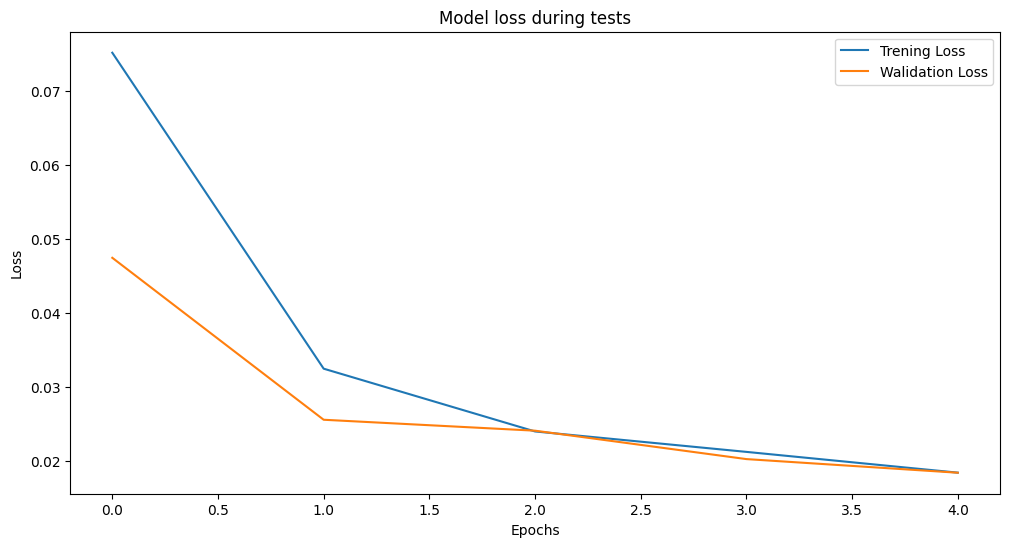

In [36]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Trening Loss')
plt.plot(history.history['val_loss'], label='Walidation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model loss during tests')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


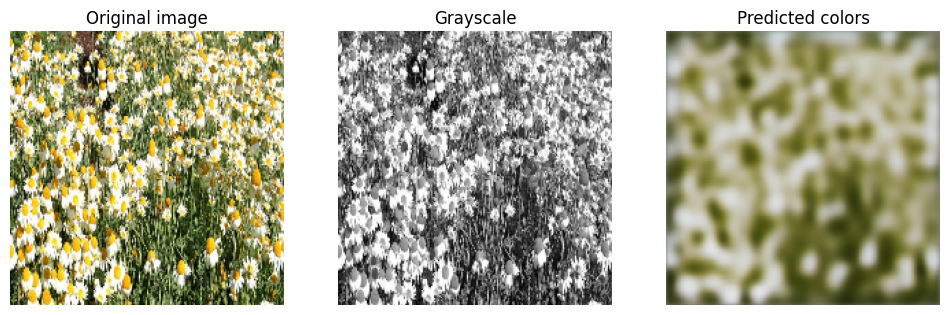

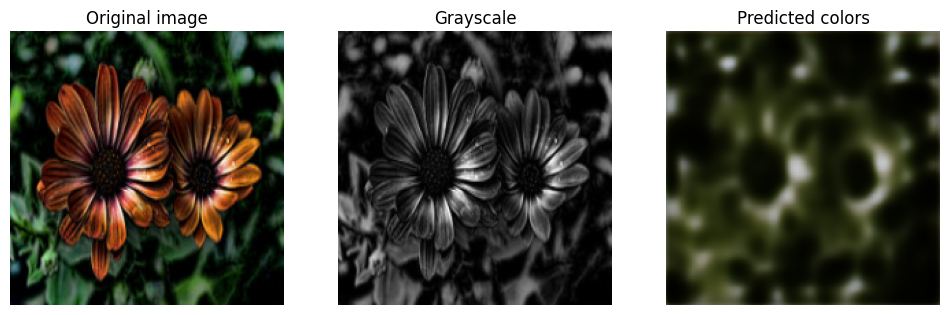

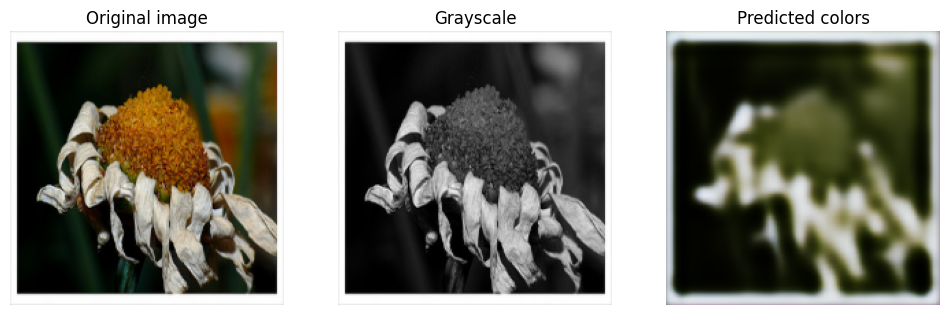

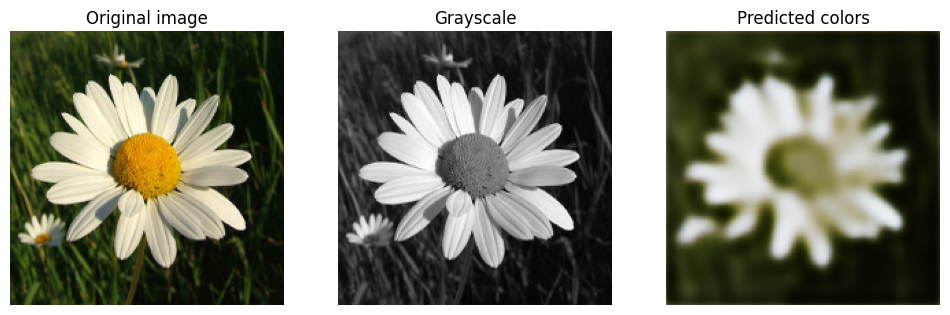

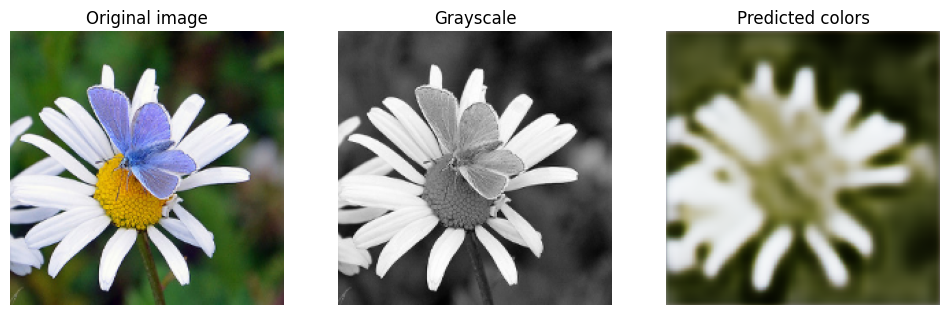

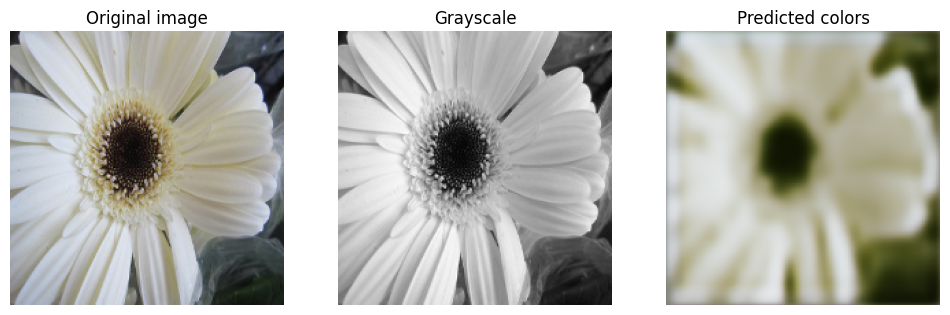

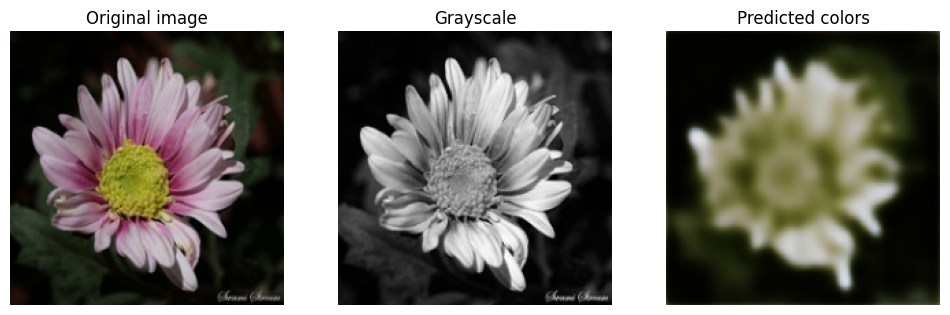

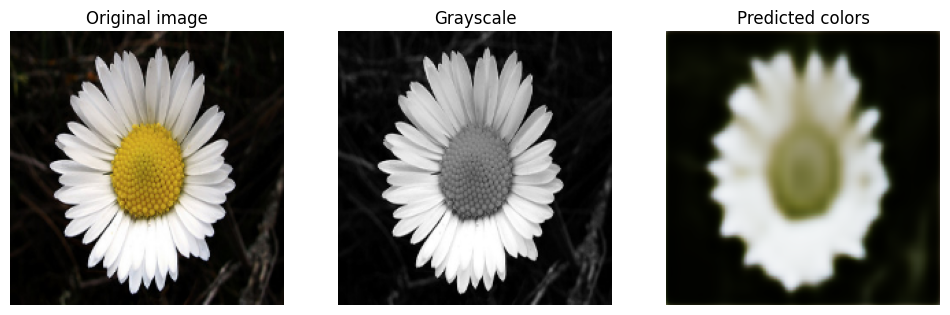

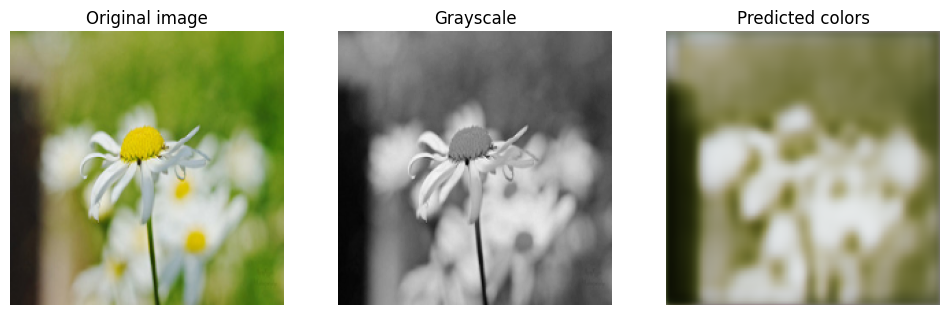

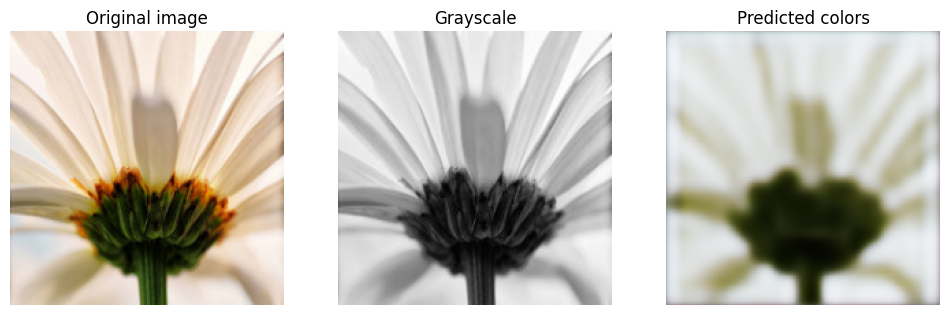

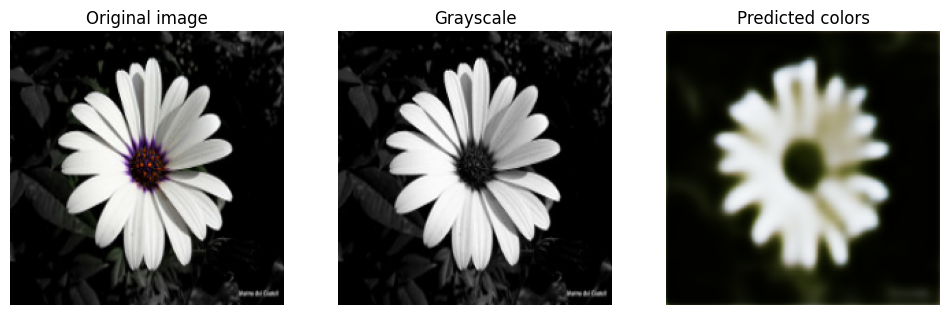

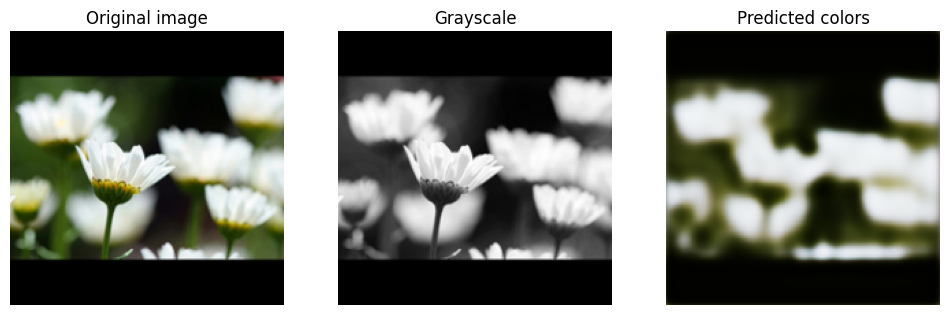

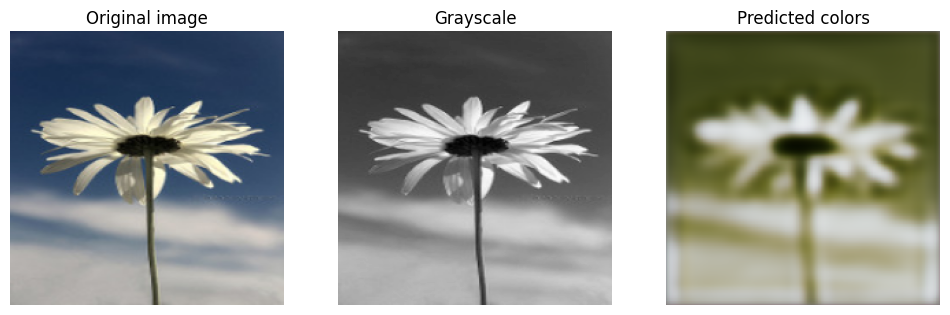

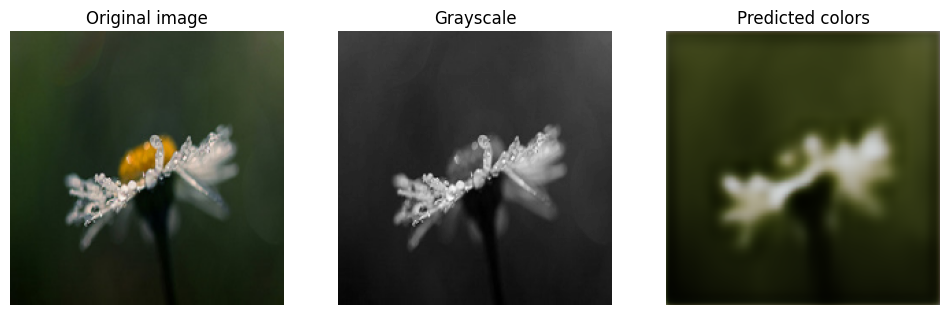

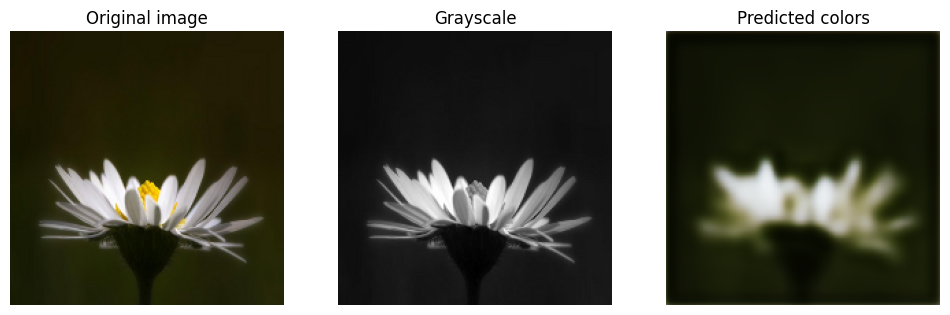

In [35]:
n = 15
predicted_images = autoencoder.predict(X_test[:n])

for i in range(n):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.title("Original image")
    plt.imshow(Y_test[i])
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Grayscale")
    plt.imshow(X_test[i].reshape(200, 200), cmap='gray')
    plt.axis('off')
    

    plt.subplot(1, 3, 3)
    plt.title("Predicted colors")
    plt.imshow(predicted_images[i])
    plt.axis('off')

    plt.show()

### `Step 4: Let's make our model perfect.`